# 🦒 Fine-tuning Cellpose with BioEngine ⚙️☁️

## Installation and module imports

In [15]:
try:
    # For pyodide in the browser
    import micropip

    await micropip.install(["pyodide-http", "hypha-rpc", "httpx", "kaibu-utils", "matplotlib", "tifffile", "numpy==1.26.4"])

    # 2. Patch requests
    import pyodide_http

    pyodide_http.patch_all()  # Patch all libraries
except ImportError:
    # For native python with pip
    import subprocess

    subprocess.call(["pip", "install", "hypha-rpc", "httpx", "kaibu-utils", "matplotlib", "tifffile", "numpy==1.26.4"])

import zipfile
from pathlib import Path

import httpx
import matplotlib.pyplot as plt
import numpy as np
from hypha_rpc import connect_to_server, login
from tifffile import imread

In [16]:
# Server URL: For this demo we will use the hypha.aicell.io server
SERVER_URL = "https://hypha.aicell.io"

### Connect to the server

In [17]:
token = await login({"server_url": SERVER_URL})

server = await connect_to_server(
    {"server_url": SERVER_URL, "token": token}
)
workspace = server.config.workspace

print(f"Connected to workspace: {workspace}")

artifact_manager = await server.get_service("public/artifact-manager")

Please open your browser and login at https://hypha.aicell.io/public/apps/hypha-login/?key=3BziNHUWx2nZvmcRg7NgGC
Connected to workspace: ws-user-github|49943582


### Access the BioEngine deployments

A public BioEngine instance is available with the service ID `bioimage-io/bioengine-apps`

In [18]:
PUBLIC_BIOENGINE = "bioimage-io/bioengine-apps"

bioengine = await server.get_service(PUBLIC_BIOENGINE)

If you have started your own BioEngine instance, you can first list your deployment services and then 

In [19]:
services = await server.list_services({"type": "bioengine-apps"})

for service in services:
    print(f"BioEngine apps service ID: {service.id}")
    PRIVATE_BIOENGINE = service.id

if len(services) == 0:
    print(f"No BioEngine apps service available in workspace '{server.config.workspace}'.")

bioengine = await server.get_service(PRIVATE_BIOENGINE)

BioEngine apps service ID: ws-user-github|49943582/CzPYgNED8t85WgTwWA2uHz:bioengine-apps


### Visualize some collected data

In [20]:
data_dir = "/data/nmechtel/bioengine-worker/data/hpa_demo"

In [21]:
data_dir = Path(data_dir)
annotations_dir = data_dir / "annotations"

# List to hold pairs of image and corresponding annotation masks
image_annotation_pairs = []

# Get list of all images and annotations
annotation_files = list(annotations_dir.glob("*.tif"))

# Iterate through each annotation file
for annotation_file in annotation_files:
    annotation_name = annotation_file.name
    image_name = annotation_name.split("_mask_")[0]
    image_file = data_dir / f"{image_name}.tif"

    image_annotation_pairs.append((image_file, annotation_file))


# Print the number of annotations
print(f"Number of annotations: {len(image_annotation_pairs)}")

Number of annotations: 6


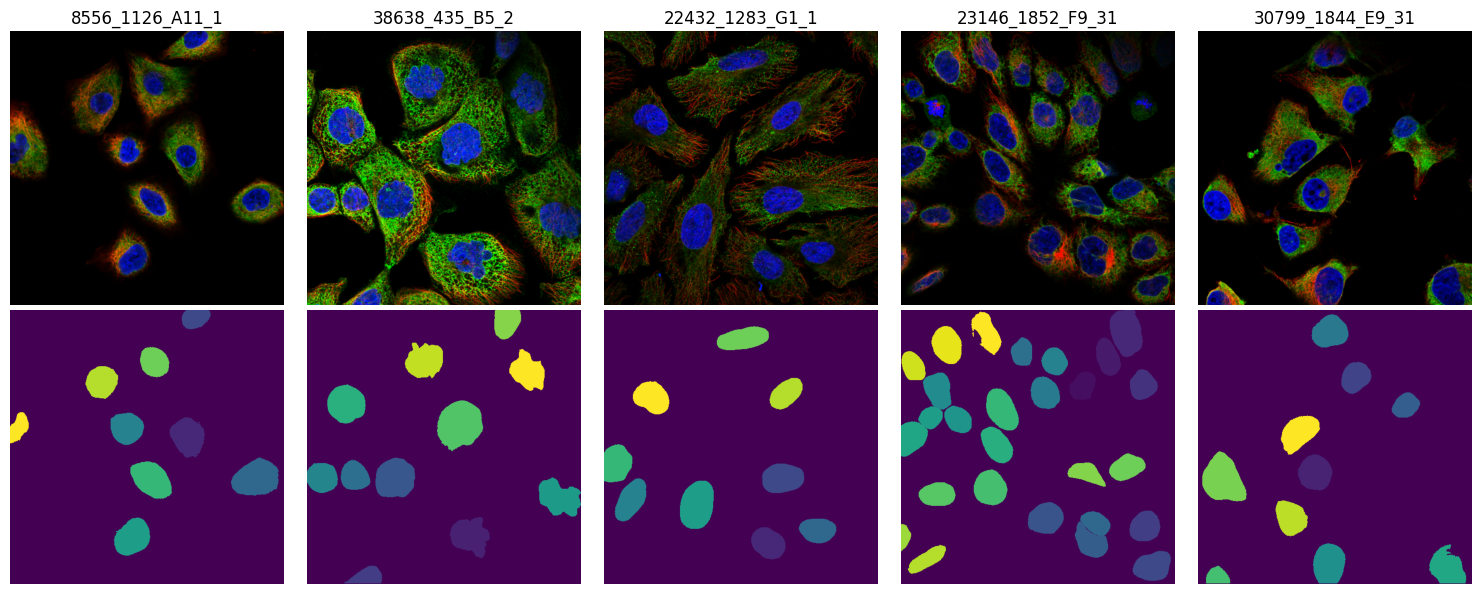

In [22]:
assert len(image_annotation_pairs) >= 5

# Plot several random annotations
choices = np.random.choice(len(image_annotation_pairs), 5, replace=False)
plt.figure(figsize=(15, 6))

for i in range(5):
    plt.subplot(2, 5, i + 1)
    img = imread(image_annotation_pairs[choices[i]][0])
    plt.imshow(img.transpose(1, 2, 0))
    plt.title(f"{image_annotation_pairs[choices[i]][0].stem}")
    plt.axis("off")

    plt.subplot(2, 5, i + 6)
    mask = imread(image_annotation_pairs[choices[i]][1])
    plt.imshow(mask)
    plt.axis("off")

plt.tight_layout()
plt.show()

### Upload the annotated dataset to the collection

First, create the BioImage.IO Colab collection (if not already created)

In [23]:
# Check if the data collection exists
collection_id = f"{workspace}/bioimageio-colab"

try:
    await artifact_manager.read(collection_id)
except Exception as e:
    expected_error = f'KeyError: "Artifact with ID \'{collection_id}\' does not exist."'
    if str(e).strip().endswith(expected_error):
        print(f"Collection '{collection_id}' does not exist. Creating it.")

    collection_manifest = {
        "name": "BioImage.IO Colab",
        "description": "A collection of annotated images from BioImage.IO Colab and fine-tuned models.",
    }
    collection = await artifact_manager.create(
        alias=collection_id,
        type="collection",
        manifest=collection_manifest,
        config={"permissions": {"*": "r", "@": "r+"}}
    )
    print(f"BioImage.IO Colab data collection created with ID: {collection.id}")

Upload the annotated dataset to the BioImage.IO Colab collection

In [24]:
# Create a zip file of the image_annotation_pairs
data_path = data_dir / "data.zip"
with zipfile.ZipFile(data_path, 'w') as zipf:
    for img_file, mask_file in image_annotation_pairs:
        zipf.write(img_file, img_file.relative_to(data_dir))
        zipf.write(mask_file, mask_file.relative_to(data_dir))

In [26]:
with zipfile.ZipFile(data_path, 'r') as zipf:
    zipf.extractall(data_dir)

In [10]:
# Create a zip file of the image_annotation_pairs
data_path = data_dir / "data.zip"
with zipfile.ZipFile(data_path, 'w') as zipf:
    for img_file, mask_file in image_annotation_pairs:
        zipf.write(img_file, img_file.relative_to(data_dir))
        zipf.write(mask_file, mask_file.relative_to(data_dir))


# Load the dataset content
dataset_content = data_path.read_bytes()

# Create or update the dataset artifact
dataset_manifest = {
    "name": "HPA Demo",
    "description": "An annotated dataset for Cellpose finetuning",
    "type": "data",
}
data_artifact_alias = "hpa-demo"

try:
    # Edit the existing deployment and stage it for review
    artifact = await artifact_manager.edit(
        artifact_id=f"{workspace}/{data_artifact_alias}",
        manifest=dataset_manifest,
        type=dataset_manifest["type"],
        stage=True,
    )
except:
    # If the artifact does not exist, create it
    artifact = await artifact_manager.create(
        alias=data_artifact_alias,
        parent_id=collection_id,
        manifest=dataset_manifest,
        type=dataset_manifest["type"],
        stage=True,
    )
    print(f"Artifact created with ID: {artifact.id}")

# Upload manifest.yaml
manifest_url = await artifact_manager.put_file(artifact.id, file_path="manifest.yaml")
async with httpx.AsyncClient(timeout=30) as client:
    response = await client.put(manifest_url, data=dataset_manifest)
    response.raise_for_status()
    print(f"Uploaded manifest.yaml to artifact")

# Upload the dataset content as a zip file
data_url = await artifact_manager.put_file(artifact.id, file_path="data.zip")
async with httpx.AsyncClient(timeout=30) as client:
    response = await client.put(data_url, data=dataset_content)
    response.raise_for_status()
    print(f"Uploaded data.zip to artifact")

# Commit the artifact
await artifact_manager.commit(artifact_id=artifact.id)
print(f"Committed artifact with ID: {artifact.id}")

Uploaded manifest.yaml to artifact
Uploaded data.zip to artifact
Committed artifact with ID: ws-user-github|49943582/hpa-demo


### Choose a pre-trained model to fine-tune

In [11]:
pretrained_models = await bioengine.bioimage_io_cellpose_finetuning.list_pretrained_models()

print("Available pretrained models: \n -", '\n - '.join(pretrained_models))

Available pretrained models: 
 - cyto
 - cyto3
 - nuclei
 - tissuenet_cp3
 - livecell_cp3
 - yeast_PhC_cp3
 - yeast_BF_cp3
 - bact_phase_cp3
 - bact_fluor_cp3
 - deepbacs_cp3


Here we choose the `cellpose` model `cyto3` for cytoplasm segmentation.

In [12]:
initial_model = "cyto3"

### Prepare the data for training

Create an artifact for the fine-tuned Cellpose model

In [ ]:
model_manifest = {
    "name": "Finetuned Cellpose model",
    "description": f"Finetuned model for Cellpose {initial_model}",
    "type": "model",
}
model_artifact_alias = f"cellpose-{initial_model}-hpa-finetuned"
finetuning_result = model_artifact_alias.replace("-", "_") + ".zip"

try:
    model_artifact = await artifact_manager.create(
        alias=model_artifact_alias,
        parent_id=collection_id,
        manifest=model_manifest,
        type=model_manifest["type"],
        stage=True,
    )
    print(f"Artifact created with ID: {model_artifact.id}")
except:
    artifact_id = f"{workspace}/{model_artifact_alias}"
    artifact_files = await artifact_manager.list_files(artifact_id)
    for file in artifact_files:
        if file.name == finetuning_result:
            print(f"The file '{finetuning_result}' already exists in the artifact '{artifact_id}'. Overwriting it.")
            break

    # Edit the existing artifact with the new manifest
    model_artifact = await artifact_manager.edit(
        artifact_id=f"{workspace}/{model_artifact_alias}",
        manifest=model_manifest,
        type=model_manifest["type"],
        stage=True,
    )

# Create presigned URLs for data download and model upload
data_download_url = await artifact_manager.get_file(
    artifact_id=f"{workspace}/{data_artifact_alias}", file_path="data.zip"
)

model_upload_url = await artifact_manager.put_file(
    model_artifact.id, file_path=finetuning_result
)

data = {
    "data_download_url": data_download_url,
    "result_upload_url": model_upload_url,
    "initial_model": initial_model,
}

The file 'cellpose_cyto3_hpa_finetuned.zip' already exists in the artifact 'ws-user-github|49943582/cellpose-cyto3-hpa-finetuned'. Overwriting it.


### Run the Cellpose fine-tuning

In [14]:
result = await bioengine.bioimage_io_cellpose_finetuning.train(data=data)
assert result["status"] == "success", f"Training failed: {result['error']}"

# Save the finetuned model to the artifact
await artifact_manager.commit(artifact_id=model_artifact.id)
print(f"Committed artifact with ID: {model_artifact.id}")

RemoteException: RemoteError:Traceback (most recent call last):
             ^^^^^^^^^^^^
  File "/app/bioengine_worker/ray_deployment_manager.py", line 249, in create_deployment_function
    raise e
  File "/app/bioengine_worker/ray_deployment_manager.py", line 241, in create_deployment_function
    result = await getattr(app_handle, method_name).remote(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/site-packages/ray/serve/handle.py", line 530, in __await__
    result = yield from obj_ref.__await__()
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ray.exceptions.RayTaskError(IndexError): [36mray::ServeReplica:bioimage_io_cellpose_finetuning:CellposeFinetune.handle_request_with_rejection()[39m (pid=1105, ip=192.168.192.2, actor_id=3f2a6b4d37d2b5671836bbee01000000, repr=<ray.serve._private.replica.ServeReplica:bioimage_io_cellpose_finetuning:CellposeFinetune object at 0x7f7d1c77ff10>)
    yield await self._user_callable_wrapper.call_user_method(
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/site-packages/ray/serve/_private/replica.py", line 1163, in call_user_method
    raise e from None
ray.exceptions.RayTaskError: [36mray::ServeReplica:bioimage_io_cellpose_finetuning:CellposeFinetune.handle_request_with_rejection()[39m (pid=1105, ip=192.168.192.2)
  File "/usr/local/lib/python3.11/site-packages/ray/serve/_private/utils.py", line 168, in wrap_to_ray_error
    raise exception
  File "/usr/local/lib/python3.11/site-packages/ray/serve/_private/replica.py", line 1145, in call_user_method
    await self._call_func_or_gen(
  File "/usr/local/lib/python3.11/site-packages/ray/serve/_private/replica.py", line 869, in _call_func_or_gen
    result = await result
             ^^^^^^^^^^^^
  Plugin script, line 324, in train
  Plugin script, line 169, in _evaluate_cellpose
IndexError: list index out of range
Exception: Traceback (most recent call last):
             ^^^^^^^^^^^^
  File "/app/bioengine_worker/ray_deployment_manager.py", line 249, in create_deployment_function
    raise e
  File "/app/bioengine_worker/ray_deployment_manager.py", line 241, in create_deployment_function
    result = await getattr(app_handle, method_name).remote(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/site-packages/ray/serve/handle.py", line 530, in __await__
    result = yield from obj_ref.__await__()
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ray.exceptions.RayTaskError(IndexError): [36mray::ServeReplica:bioimage_io_cellpose_finetuning:CellposeFinetune.handle_request_with_rejection()[39m (pid=1105, ip=192.168.192.2, actor_id=3f2a6b4d37d2b5671836bbee01000000, repr=<ray.serve._private.replica.ServeReplica:bioimage_io_cellpose_finetuning:CellposeFinetune object at 0x7f7d1c77ff10>)
    yield await self._user_callable_wrapper.call_user_method(
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/site-packages/ray/serve/_private/replica.py", line 1163, in call_user_method
    raise e from None
ray.exceptions.RayTaskError: [36mray::ServeReplica:bioimage_io_cellpose_finetuning:CellposeFinetune.handle_request_with_rejection()[39m (pid=1105, ip=192.168.192.2)
  File "/usr/local/lib/python3.11/site-packages/ray/serve/_private/utils.py", line 168, in wrap_to_ray_error
    raise exception
  File "/usr/local/lib/python3.11/site-packages/ray/serve/_private/replica.py", line 1145, in call_user_method
    await self._call_func_or_gen(
  File "/usr/local/lib/python3.11/site-packages/ray/serve/_private/replica.py", line 869, in _call_func_or_gen
    result = await result
             ^^^^^^^^^^^^
  Plugin script, line 324, in train
  Plugin script, line 169, in _evaluate_cellpose
IndexError: list index out of range


### Visualize the training progress

Let's download the results

In [ ]:
result_upload_url = await artifact_manager.put_file(
    artifact_id=model_artifact.id,
    file_path=finetuning_result,
)

zip_file_path = tmp_dir / "data.zip"

async with httpx.AsyncClient(timeout=30) as client:
    response = await client.get(download_url)
    response.raise_for_status()
    zip_file_path.write_bytes(response.content)

# Unzip the downloaded file
with zipfile.ZipFile(zip_file_path, "r") as zip_ref:
    zip_ref.extractall(tmp_dir)

In [14]:
import matplotlib.pyplot as plt

# Extract training losses from the result
train_losses = result["train_losses"]
epochs = range(1, len(train_losses) + 1)

# Plot the training loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, 'bo-', linewidth=2, markersize=8)
plt.title('Training Loss During Cellpose Fine-tuning', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.grid(True)
plt.xticks(epochs)
plt.ylim(bottom=0)  # Start y-axis at 0

plt.tight_layout()
plt.show()

NameError: name 'result' is not defined

Number of test samples: 2
Image shape: (3, 512, 512)
Predicted mask shape: (512, 512)
True mask shape: (512, 512)


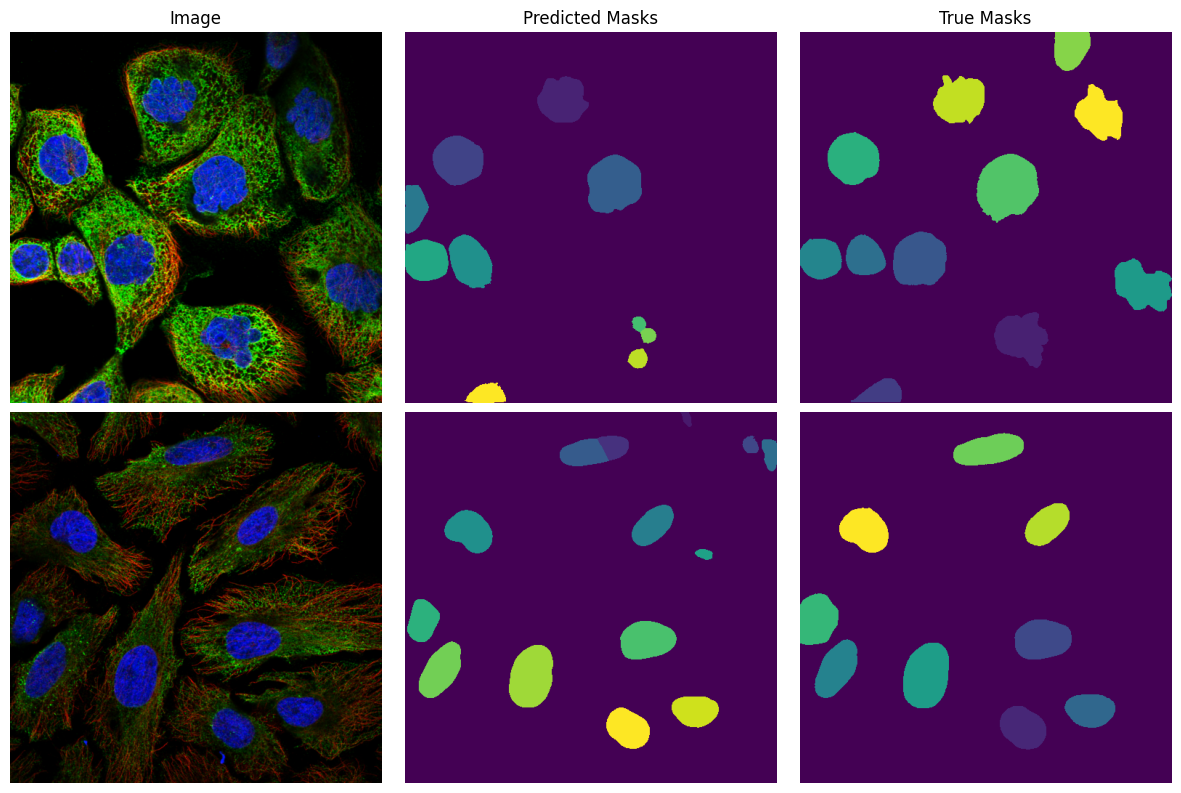

In [17]:
import numpy as np

import matplotlib.pyplot as plt

# Extract the prediction data from the result
predictions = result["predictions"]
n_samples = len(predictions)

# Print some information about the prediction results
print(f"Number of test samples: {n_samples}")
print(f"Image shape: {predictions[0][0].shape}")
print(f"Predicted mask shape: {predictions[0][2].shape}")
print(f"True mask shape: {predictions[0][1].shape}")

# Plot the images, predictions, and ground truth labels
plt.figure(figsize=(12, 4 * n_samples))

for i in range(n_samples):
    # Plot the image
    plt.subplot(n_samples, 3, i * 3 + 1)
    plt.imshow(predictions[i][0].transpose(1, 2, 0))
    plt.title("Image" if i == 0 else "")
    plt.axis("off")
    
    # Plot the predicted labels
    plt.subplot(n_samples, 3, i * 3 + 2)
    plt.imshow(predictions[i][2])
    plt.title("Predicted Masks" if i == 0 else "")
    plt.axis("off")
    
    # Plot the true labels
    plt.subplot(n_samples, 3, i * 3 + 3)
    plt.imshow(predictions[i][1])
    plt.title("True Masks" if i == 0 else "")
    plt.axis("off")

plt.tight_layout()
plt.show()

NameError: name 'test_data' is not defined

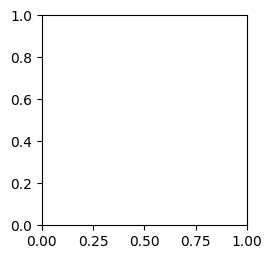

In [15]:
plt.figure(figsize=(9, 6))

for i in range(2):  # Two rows
    # Plot the image
    plt.subplot(2, 3, i * 3 + 1)
    plt.imshow(test_data[i].transpose(1, 2, 0))
    plt.axis("off")
    if i == 0:
        plt.title("Image")

    # Plot the predicted labels
    plt.subplot(2, 3, i * 3 + 2)
    plt.imshow(masks[i])
    plt.axis("off")
    if i == 0:
        plt.title("Predicted Labels")

    # Plot the true labels
    plt.subplot(2, 3, i * 3 + 3)
    plt.imshow(test_labels[i])
    plt.axis("off")
    if i == 0:
        plt.title("True Labels")

plt.tight_layout()
plt.show()